# Dugaan Bayes, DAG, dan Pemrograman Probabilistik: Studi Kasus Regresi Harga Rumah

Beberapa waktu ini saya sedang mempelajari tentang pemrograman probabilistik. Sebuah paradigma yang digunakan dalam statistika komputasional. Apa itu statistika komputasional? Well, statistika adalah keilmuan yang bertarung dengan ketidakpastian. Dulu saat belum ada teknologi komputer, statistikawan melakukan statistik secara tangan kosong. Alias menerapkan solusi statistik secara analitik.

Seiring berkembangnya zaman, komputer hadir untuk memudahkan kerja manusia. Terima kasih kepada Turing dan Goedel yang menurut saya adalah pionir awal komputer. Menariknya, mereka tanpa sengaja membuat konsep komputer yang pada saat itu digunakan untuk menyelesaikan persoalan filsafat. Tapi mungkin ini cerita untuk lain waktu. Kembali ke komputer, adanya komputer ini mengizinkan manusia untuk menyelesaikan permasalahan yang sebelumnya tidak bisa diselesaikan secara analitik, mungkin karena tidak kontinyu atau rumit, menjadi bisa didekati secara numerik. Salah satu bidang yang kecipratan dengan adanya komputer adalah statistik dengan munculnya statistika komputasional.

Sebenarnya, kita sudah sering menggunakan statistika komputasional tanpa sadar. Mulai dari tingkat lanjut seperti kecerdasan buatan hingga yang sudah ada di kehidupan sehari-hari seperti excel. Ya... excel. Di dalam excel ada banyak fungsi statistik seperti kalkulasi p-value, solver, distribusi dan lain-lain. Semua itu adalah pengejawantahan atau pendekatan dari metode numerik terhadap metode analitik.

Sebelum sekitar 50 tahun terakhir ini, ada satu metode analitik dalam statistika yang masih susah untuk didekati secara numerik karena keterbatasan komputer. Metode itu adalah metode dugaan Bayes. Perbedaan metode ini dengan metode dari paradigma frekuentis seperti p-value adalah metode dugaan bayes mencoba untuk mengkuantifikasi ketidakpastian parameter yang paradigma frekuentis tidak coba lakukan. Akan panjang menjelaskan perbedaan paradigma Bayes dan paradigma frekuentis. Saya sudah coba menjelaskannya di sini tapi dalam bahasa Inggris.

Dewasa ini, dikarenakan perkembangan komputer, perkawinan metode dugaan bayes dengan metode numerik berhasil dilakukan dengan menghasilkan pemrograman probabilistik. Buku Statistical Rethinking karya Richard McElreath membicarakan mengenai pemanfaatan pemrograman probabilistik dengan komprehensif.

Jika bicara mengenai keuntungan menggunakan pemrograman probabilistik dibanding metode statistika komputasional lainnya, pemrograman probabilistik tidak hanya mampu melakukan dugaan seperti metode lainnya lakukan tapi juga dapat digunakan menganalisis darimana dugaan itu berasal. Salah satu hasilnya adalah explainable machine learning yang hadir sebagai solusi permasalahan kotak hitam machine learning.

Di buku Statistical Rethinking juga dijelaskan penggunaan DAG atau directed acyclic graph. DAG adalah diagram yang dapat digunakan untuk mengetahui kausalitas antar variabel.

Sebagai contoh mungkin kita bisa ambil studi kasus regresi harga rumah di California yang sudah ada datanya di Google Colab.

In [1]:
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 8.1 MB/s eta 0:00:0000:01


In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.infer import Predictive
from numpyro import handlers

import jax.numpy as jnp
from jax import lax, random, vmap

In [3]:
train_path = '/content/sample_data/california_housing_train.csv'
test_path = '/content/sample_data/california_housing_test.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [4]:
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


Data yang ada di Google Colab terdiri dari 9 variabel yaitu:

1. Latitude di suatu area
2. Longitude di suatu area
3. Median umur rumah di suatu area
4. Jumlah ruangan di suatu area
5. Jumlah kamar tidur di suatu area
6. Populasi di suatu area
7. Jumlah keluarga di suatu area
8. Median pendapatan di suatu area
9. Median harga rumah di suatu area

Di sini akan dicoba regresi median harga rumah terhadap 8 variabel lainnya. Mudah bukan? tinggal masukin saja variabel-variabel ini ke regresi linier dan jadi deh. Eits, tunggu dulu. Kebanyakan perangkat lunak yang sudah disediakan akan memperlakukan semua variabel tadi secara setara. Mungkin saja ada variabel-variabel yang aneh. Contohnya latitude dan longitude. Latitude dan longitude sudah seharusnya tidak saling mempengaruhi. Latitude suatu area tidak bisa digunakan untuk memprediksi longitude suatu area. Di sisi lain, latitude bisa mempengaruhi populasi dari suatu daerah. Mungkin saja orang-orang lebih prefer tinggal di daerah hangat daripada di daerah dingin. Lalu populasi juga bisa mempengaruhi jumlah keluarga yang ada. Jumlah keluarga bisa mempengaruhi pendapatan. Lalu pendapatan bisa mempengaruhi populasi. Loh balik lagi... ya memang permasalahan dunia nyata itu kompleks dan tidak tereduksi seperti apa yang kita dapat waktu sekolah.

DAG hadir untuk memudahkan analisis permasalahan kompleks ini. Menggunakan tools dari library NetworkX, kita bisa memodelkan interaksi antar variabel ini ke sebuah model jaringan. Contohnya, pengaruh populasi ke jumlah keluarga ke jumlah pendapatan dan pengaruh populasi ke jumlah pendapatan dapat dimodelkan menjadi

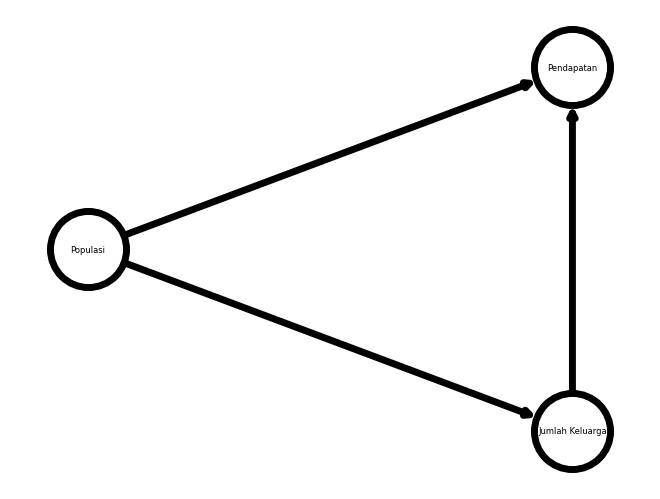

In [5]:
G = nx.DiGraph()

nodes = ["Populasi", "Jumlah Keluarga", "Pendapatan"]
edges = [("Populasi", "Jumlah Keluarga"),
         ("Jumlah Keluarga", "Pendapatan"),
         ("Populasi", "Pendapatan")]

G.add_nodes_from(nodes)
G.add_edges_from(edges)

options = {
    "font_size": 6,
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}

nx.draw_shell(G, **options, with_labels=True)
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")
plt.show()

Inilah yand disebutt dengan DAG, graf terarah dan tak bersiklus. DAG dapat digunakan untuk melihat visualisasi interaksi antar variabel.

Pada kassus ini, interaksi yang dimodelkan antara lain:

- Longitude mungkin berhubungan dengan populasi
- Latitude mungkin berhubungan dengan populasi
- Longitude mungkin berhubungan dengan pendapatan
- Longitude mungkin berhubungan dengan populasi
- Jumlah kamar tidur mungkin berhubungan dengan jumlah ruangan
- Populasi mungkin berhubungan dengan jumlah ruangan
- Pendapatan mungkin berhubungan dengan jumlah ruangan
- Populasi mungkin berhubungan dengan jumlah kamar tidur
- Pendapatan mungkin berhubungan dengan jumlah kamar tidur
- Jumlah rumah tangga mungkin berhubungan dengan populasi
- Pendapatan mungkin berhubungan dengan populasi or vice versa
- Pendapaatan mungkin berhubungan dengan jumlah rumah tangga

Interaksi ini dimodelkan untuk meregresi harga rumah berdasarkan 8 variabel tersebut

In [6]:
nodes = ["Longitude", "Latitude", "Jumlah Ruangan", "Jumlah Kamar Tidur", "Umur Rumah", "Populasi", "Jumlah Keluarga", "Pendapatan", "Harga Rumah"]
edges = [("Longitude", "Harga Rumah"),
         ("Latitude", "Harga Rumah"),
         ("Jumlah Ruangan", "Harga Rumah"),
         ("Jumlah Kamar Tidur", "Harga Rumah"),
         ("Umur Rumah", "Harga Rumah"),
         ("Populasi", "Harga Rumah"),
         ("Jumlah Keluarga", "Harga Rumah"),
         ("Pendapatan", "Harga Rumah"),
         ("Longitude", "Populasi"),
         ("Latitude", "Populasi"),
         ("Longitude", "Pendapatan"),
         ("Latitude", "Pendapatan"),
         ("Jumlah Kamar Tidur", "Jumlah Ruangan"),
         ("Populasi", "Jumlah Ruangan"),
         ("Pendapatan", "Jumlah Ruangan"),
         ("Populasi", "Jumlah Kamar Tidur"),
         ("Pendapatan", "Jumlah Kamar Tidur"),
         ("Jumlah Keluarga", "Populasi"),
         ("Pendapatan", "Populasi"),
         ("Pendapatan", "Jumlah Keluarga")]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

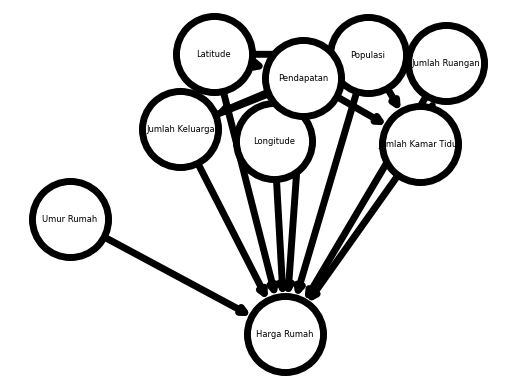

In [7]:
options = {
    "font_size": 6,
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}

nx.draw_networkx(G, **options, with_labels=True)
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")
plt.show()

# Dugaan Bayes

Untuk memudahkan interpretasi dan komputasi, dilakukan transformasi skala untuk sembilan variabel.

In [8]:
df_train['longitude'] = (df_train['longitude'] - df_train['longitude'].mean())/df_train['longitude'].std(ddof=1)
df_train['latitude'] = (df_train['latitude'] - df_train['latitude'].mean())/df_train['latitude'].std(ddof=1)
df_train['housing_median_age'] = (df_train['housing_median_age'] - df_train['housing_median_age'].min())/df_train['housing_median_age'].max()
df_train['total_rooms'] = (df_train['total_rooms'] - df_train['total_rooms'].min())/df_train['total_rooms'].max()
df_train['total_bedrooms'] = (df_train['total_bedrooms'] - df_train['total_bedrooms'].min())/df_train['total_bedrooms'].max()
df_train['population'] = (df_train['population'] - df_train['population'].min())/df_train['population'].max()
df_train['households'] = (df_train['households'] - df_train['households'].min())/df_train['households'].max()
df_train['median_income'] = (df_train['median_income'] - df_train['median_income'].min())/df_train['median_income'].max()
df_train['median_house_value'] = (df_train['median_house_value'] - df_train['median_house_value'].min())/df_train['median_house_value'].max()

In [9]:
df_test['longitude'] = (df_test['longitude'] - df_test['longitude'].mean())/df_test['longitude'].std(ddof=1)
df_test['latitude'] = (df_test['latitude'] - df_test['latitude'].mean())/df_test['latitude'].std(ddof=1)
df_test['housing_median_age'] = (df_test['housing_median_age'] - df_test['housing_median_age'].min())/df_test['housing_median_age'].max()
df_test['total_rooms'] = (df_test['total_rooms'] - df_test['total_rooms'].min())/df_test['total_rooms'].max()
df_test['total_bedrooms'] = (df_test['total_bedrooms'] - df_test['total_bedrooms'].min())/df_test['total_bedrooms'].max()
df_test['population'] = (df_test['population'] - df_test['population'].min())/df_test['population'].max()
df_test['households'] = (df_test['households'] - df_test['households'].min())/df_test['households'].max()
df_test['median_income'] = (df_test['median_income'] - df_test['median_income'].min())/df_test['median_income'].max()
df_test['median_house_value'] = (df_test['median_house_value'] - df_test['median_house_value'].min())/df_test['median_house_value'].max()

Dari sembilan variabel, hanya dua variabel yaitu latitude dan longitude yang menggunakan skala standar. Kenapa? karena untuk dua variabel ini, nilai negatif memiliki arti pada pembacaan data sehingga min-max tidak bisa dilakukan.

In [10]:
columns = df_train.columns
features, target = columns[:-1], columns[-1]
X_train, y_train = df_train[features], df_train[target]
X_test, y_test = df_test[features], df_test[target]

In [11]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,2.619288,-0.671500,0.269231,0.147877,0.198914,0.028362,0.077442,0.066246
1,2.539494,-0.573248,0.346154,0.201597,0.294802,0.031557,0.075962,0.088006
2,2.494610,-0.905436,0.307692,0.018926,0.026843,0.009248,0.019073,0.076733
3,2.489623,-0.928830,0.250000,0.039513,0.052133,0.014349,0.036994,0.179452
4,2.489623,-0.961581,0.365385,0.038274,0.050427,0.017404,0.042914,0.095006


In [12]:
latitude = X_train['latitude']
longitude = X_train['longitude']
housing_median_age = X_train['housing_median_age']
total_rooms = X_train['total_rooms']
total_bedrooms = X_train['total_bedrooms']
population = X_train['population']
households = X_train['households']
median_income = X_train['median_income']

median_house_value = y_train

dat_slim = {
    "latitude": X_train['latitude'].values,
    "longitude":  X_train['longitude'].values,
    "housing_median_age": X_train['housing_median_age'].values,
    "total_rooms": X_train['total_rooms'].values,
    "total_bedrooms": X_train['total_bedrooms'].values,
    "population": X_train['population'].values,
    "households": X_train['households'].values,
    "median_income": X_train['median_income'].values,
    "median_house_value": y_train.values
}

In [16]:
def model(latitude=None, longitude=None, housing_median_age=None, total_rooms=None, total_bedrooms=None, population=None, households=None, median_income=None, median_house_value=None):
    Bla = numpyro.sample("latitude", dist.Normal(0.5, 0.2))
    Blo = numpyro.sample("longitude", dist.Normal(0.5, 0.2))
    Bha = numpyro.sample("housing_median_age", dist.Normal(0.5, 0.2))
    Btr = numpyro.sample("total_rooms", dist.Normal(0.5, 0.2))
    Btb = numpyro.sample("total_bedrooms", dist.Normal(0.5, 0.2))
    Bpo = numpyro.sample("population", dist.Normal(0.5, 0.2))
    Bho = numpyro.sample("households", dist.Normal(0.5, 0.2))
    Bmi = numpyro.sample("median_income", dist.Normal(0.5, 0.2))

    Blapo = numpyro.sample("interaction_latitude_population", dist.Normal(0, 0.2))
    Blopo = numpyro.sample("interaction_longitude_population", dist.Normal(0, 0.2))
    Blami = numpyro.sample("interaction_latitude_income", dist.Normal(0, 0.2))
    Blomi = numpyro.sample("interaction_longitude_income", dist.Normal(0, 0.2))
    Btrtb = numpyro.sample("interaction_total_rooms_total_bedrooms", dist.Normal(0, 0.2))
    Bpotr = numpyro.sample("interaction_population_total_rooms", dist.Normal(0, 0.2))
    Bmitr = numpyro.sample("interaction_income_rooms", dist.Normal(0, 0.2))
    Bpotb = numpyro.sample("interaction_population_total_bedrooms", dist.Normal(0, 0.2))

    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", Bla*latitude + Blo*longitude + Bha*housing_median_age + Btr*total_rooms + Btb*total_bedrooms + Bpo*population + Bho*households + Bmi*median_income + Blapo*latitude*population + Blopo*longitude*population + Btrtb*total_rooms*total_bedrooms + Blami*latitude*median_income + Blomi*longitude*median_income + Bpotr*population*total_rooms + Bmitr*median_income*total_rooms + Bpotb*population*total_bedrooms)
    #mu2 = numpyro.sample("mu2",  dist.Normal(mu, sigma))
    #numpyro.sample("rate", )
    #rate = numpyro.sample("rate", dist.Normal(mu, sigma))
    numpyro.sample("median_house_value", dist.Normal(mu, sigma), obs=median_house_value)


mcmc = MCMC(NUTS(model), num_warmup=50, num_samples=500, num_chains=1)
mcmc.run(random.PRNGKey(0), **dat_slim)

sample: 100%|██████████| 550/550 [04:27<00:00,  2.06it/s, 1023 steps of size 4.56e-03. acc. prob=0.91]


In [17]:
mcmc.print_summary(0.90)


                                              mean       std    median      5.0%     95.0%     n_eff     r_hat
                              households      0.41      0.16      0.43      0.27      0.58     33.18      1.03
                      housing_median_age      0.15      0.00      0.15      0.14      0.16     91.90      1.02
                interaction_income_rooms      0.69      0.15      0.68      0.44      0.88     45.35      1.03
             interaction_latitude_income     -0.36      0.09     -0.37     -0.41     -0.31     75.79      1.01
         interaction_latitude_population     -0.29      0.10     -0.29     -0.45     -0.15    164.48      1.02
            interaction_longitude_income     -0.32      0.09     -0.33     -0.37     -0.29     76.24      1.01
        interaction_longitude_population     -0.30      0.09     -0.31     -0.44     -0.18    152.81      1.01
   interaction_population_total_bedrooms      0.41      0.16      0.40      0.13      0.66     31.10      1.00


Dari sini, bisa dilihat hubungan-hubungan yang terjadi pada DAG di atas. Contohnya, pendapatan suatu daerah memiliki koefisien regresi sebesar 1.17 pada model di atas. Artinya, kenaikan 1 unit skala minmax pada variabel pendapatan mengakibatkan kenaikan harga rumah sebesar 1.17 unit minmax.

Poin plus dari dugaan bayes adalah metode ini dapat memodelkan ketidakpastian dari model. Jadi, selain titik tertinggi koefisien, yang biasanya di tunjukkan oleh rerata, juga bisa didapatkan interval kepercayaan setiap koefisien.

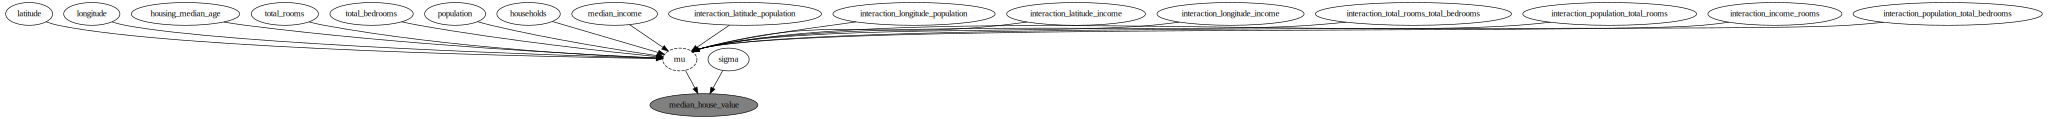

In [18]:
numpyro.render_model(model, model_kwargs=dat_slim)

In [19]:
samples = mcmc.get_samples()

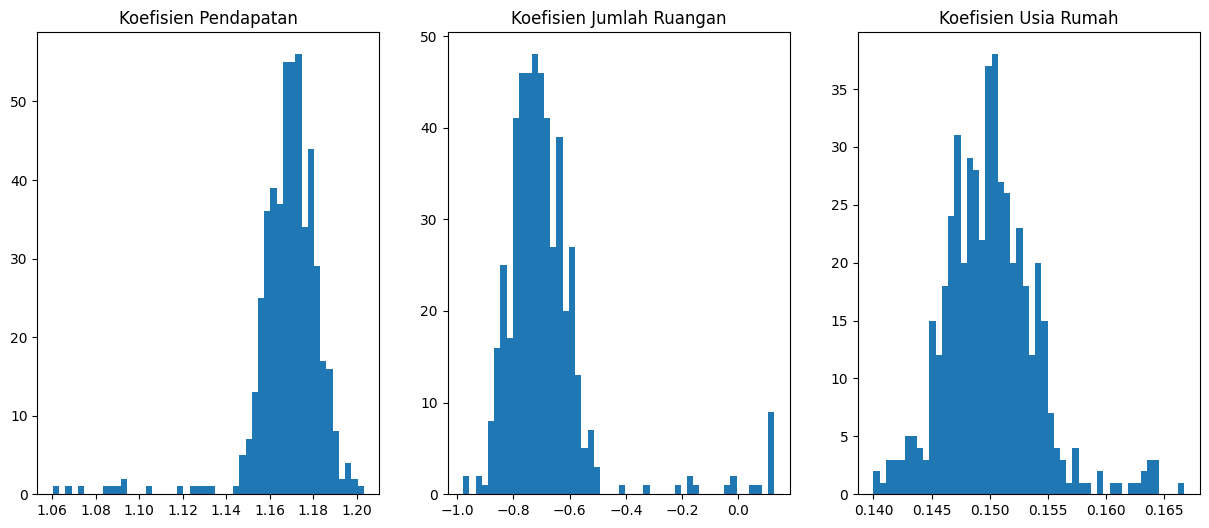

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].hist(x=samples["median_income"].flatten(), bins=50);
axs[1].hist(x=samples["total_rooms"].flatten(), bins=50);
axs[2].hist(x=samples["housing_median_age"].flatten(), bins=50);
axs[0].title.set_text('Koefisien Pendapatan')
axs[1].title.set_text('Koefisien Jumlah Ruangan')
axs[2].title.set_text('Koefisien Usia Rumah')

Dengan menggunakan dugaan bayes, bisa dilihat distribusi atau sebaran nilai koefisien dari model, inilah mengapa dugaan bayes digunakan dalam explainable machine learning.

# Uji Prediksi

Selanjutnya, dilakukan prediksi pada data yang belum pernah dilihat oleh model

In [25]:
test_latitude = X_test['latitude']
test_longitude = X_test['longitude']
test_housing_median_age = X_test['housing_median_age']
test_total_rooms = X_test['total_rooms']
test_total_bedrooms = X_test['total_bedrooms']
test_population = X_test['population']
test_households = X_test['households']
test_median_income = X_test['median_income']

median_house_value = y_test

dat_slim_test = {
    "latitude": X_test['latitude'].values,
    "longitude":  X_test['longitude'].values,
    "housing_median_age": X_test['housing_median_age'].values,
    "total_rooms": X_test['total_rooms'].values,
    "total_bedrooms": X_test['total_bedrooms'].values,
    "population": X_test['population'].values,
    "households": X_test['households'].values,
    "median_income": X_test['median_income'].values,
    "median_house_value": None
}

In [26]:
predictive = Predictive(model, samples)
predictions = predictive(random.PRNGKey(0),
                         **dat_slim_test)["median_house_value"]

pred = jnp.mean(predictions, axis=0)

In [27]:
result = pd.DataFrame((y_test.values, pred)).T
result['Absolute Error'] = np.abs(result[0]-result[1]).astype(float)

In [28]:
result

,0,1,Absolute Error
0,0.644399,0.5389652,0.105433
1,0.307999,0.28676668,0.021233
2,0.495999,0.34676784,0.149231
3,0.614999,0.5883797,0.026619
4,0.1184,0.105462305,0.012937
...,...,...,...
2995,0.404999,0.17577356,0.229226
2996,0.429399,-0.050177466,0.479577
2997,0.079,0.046390552,0.032609
2998,0.279999,0.25315034,0.026849


Text(0, 0.5, 'Jumlah data')

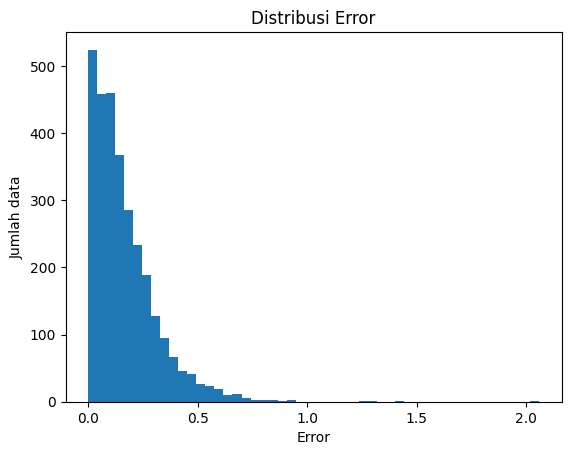

In [37]:
plt.hist(result["Absolute Error"].values, bins=50);
plt.title("Distribusi Error")
plt.xlabel("Error")
plt.ylabel("Jumlah data")

In [31]:
mae=np.mean(result['Absolute Error'])
print(f"Rerata Error Absolut: {np.round(mae, 2)}")

Rerata Error Absolut: 0.17


Text(0, 0.5, 'Nilai Prediksi')

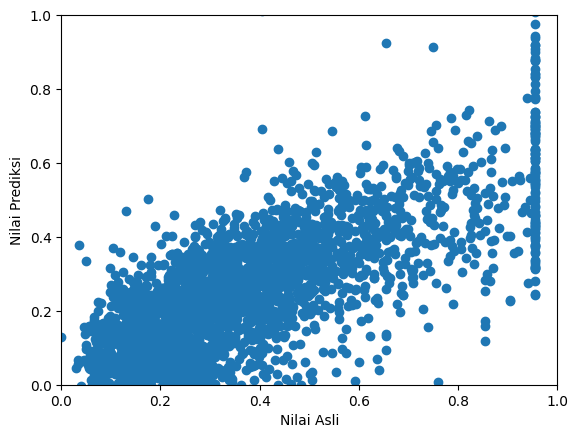

In [33]:
plt.scatter(result[0], result[1])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Nilai Asli")
plt.ylabel("Nilai Prediksi")

Dari gambar di atas, dapat dilihat semakin tinggi nilai asli, hasil prediksipun juga semakin tinggi. Tentu saja model yang sudah dibuat belum sempurna. Dengan penggunaan model lain selain model linear dengan interaksi antar variabel, bisa juga digunakan model lain yang dapat dibuat secara kustom. Contoh, di luaran model yang dibuat, digunakan distribusi gaussian yang mengizinkan nilai negatif muncul pada hasil prediksi. Hal ini seharusnya tidak dibolehkan karena harga rumah tidak mungkin negatif. Maka dapat digunakan model lebih baik dari model di atas. Inilah kelebihan dari pemrograman probabilistik.